Examine the performance of gradient-boosted random forests. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate
import numpy as np

from scipy import stats

In [2]:
TRAIN_DATA_PATH = "/content/drive/My Drive/cs189 practicum/cs189 code/pollutionTrain.csv"
TEST_DATA_PATH = "/content/drive/My Drive/cs189 practicum/cs189 code/pollutionTest.csv"

### DATA SETUP

In [3]:
trainPD = pd.read_csv(TRAIN_DATA_PATH)
testPD = pd.read_csv(TEST_DATA_PATH)

trainPD = trainPD.fillna(0)
testPD = testPD.fillna(0)

In [4]:
label_cols = ['target']

# relevant features chosen based on 1) data context and 
# 2) the SequentialFeatureSelector in regression.ipynb.
feature_cols = [
                'precipitable_water_entire_atmosphere',
                'relative_humidity_2m_above_ground',
                'temperature_2m_above_ground',
                'u_component_of_wind_10m_above_ground',
                'v_component_of_wind_10m_above_ground',
                'L3_NO2_NO2_column_number_density',
                'L3_NO2_NO2_slant_column_number_density',
                'L3_NO2_absorbing_aerosol_index',
                'L3_NO2_tropopause_pressure',
                'L3_O3_O3_column_number_density',
                'L3_CO_CO_column_number_density',
                'L3_CO_cloud_height',
                'L3_CO_H2O_column_number_density',
                'L3_HCHO_tropospheric_HCHO_column_number_density',
                'L3_SO2_SO2_column_number_density',
]

In [5]:
# partition features matrix and target matrix 
X = trainPD[feature_cols]
y = trainPD[label_cols]

# split training data into training and validation (default 75% and 25% split)
Xtrain, Xval, ytrain, yval = train_test_split(X, y, random_state=42)

# MODEL TRAINING

In [6]:
def eval_model(model, data):
  Xtrain, ytrain, Xval, yval = data
  model.fit(Xtrain, ytrain['target'])
  # print(type(model.predict(Xval)))
  ypred = model.predict(Xval).flatten()
  ypred = pd.Series(ypred, name="predicted")
  yval_reindexed = yval.reset_index().drop('index', axis=1)
  val_performance = pd.concat([yval_reindexed, ypred], axis=1)
  val_performance['error']=val_performance['predicted']-val_performance['target']
  RMSE = np.sqrt(mean_squared_error(
      val_performance['target'], val_performance['predicted']))
  
  return val_performance, RMSE

data = (Xtrain, ytrain, Xval, yval)

def visualize_error(model, data):
  val_performance, RMSE = eval_model(model, data)

  fig = plt.figure(figsize=(6,6))
  ax = fig.add_subplot(111)
  plt.scatter(x=val_performance['target'], y=val_performance['target'], alpha=0.2)
  plt.scatter(x=val_performance['target'], y=val_performance['predicted'], 
              alpha=0.2, c='orange')
  ax.set_aspect('equal')
  ax.set_xlabel('true')
  ax.set_ylabel('predicted')
  ax.legend(['true', 'predicted'])

### Initial attempt

In [7]:
model = GradientBoostingRegressor(loss='squared_error', learning_rate=0.1, 
                                  n_estimators=100, subsample=1.0, 
                                  criterion='friedman_mse')
val_performance, RMSE = eval_model(model, data)
print('RMSE: ', RMSE)
val_performance.head(10)

RMSE:  35.213592370287884


,target,predicted,error
0,79.0,71.229535,-7.770465
1,129.0,88.899205,-40.100795
2,72.0,47.570878,-24.429122
3,34.0,87.037874,53.037874
4,61.0,52.871565,-8.128435
5,198.0,204.257468,6.257468
6,26.0,59.409836,33.409836
7,124.0,64.135357,-59.864643
8,25.0,57.786984,32.786984
9,27.0,24.384501,-2.615499


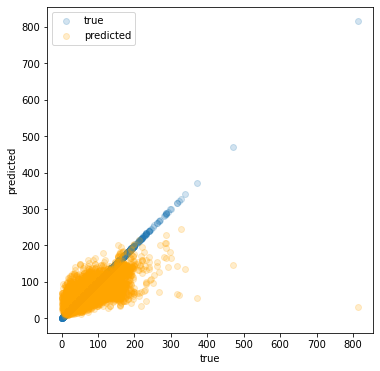

In [8]:
visualize_error(model, data)

### Hyperparameter tuning

In [22]:
param_distributions = {
    'learning_rate' : stats.expon(scale=0.5), 
    'subsample' : stats.uniform(0.5, 0.5), # (lower bound, range)
    'criterion' : ['friedman_mse', 'squared_error'], 
    'max_depth' : stats.randint(2, 8), #important to tune
    }

search = RandomizedSearchCV(GradientBoostingRegressor(n_estimators=250), 
                            param_distributions, n_iter=20, cv=5)

search.fit(Xtrain, ytrain['target']);

In [17]:
search.best_params_

{'criterion': 'squared_error',
 'learning_rate': 0.059282826738596174,
 'loss': 'squared_error',
 'max_depth': 7,
 'subsample': 0.9726121953368219}

### Cross Validation

In [26]:
model = GradientBoostingRegressor(loss='squared_error', learning_rate=0.6, 
                                  n_estimators=250, subsample=1, max_depth=7,
                                  criterion='squared_error')

scoring = {'negRMSE' : 'neg_root_mean_squared_error',
           'R2' : 'r2',
           'max_error' : 'max_error'}

scores = cross_validate(model, X, y['target'], cv=5, scoring=scoring)

print('-RMSE: ', scores['test_negRMSE'])
print('R2: ', scores['test_R2'])
print('max error: ', scores['test_max_error'])

-RMSE:  [-43.0569746  -40.4949696  -41.36364515 -42.76175093 -40.98783753]
R2:  [0.17489139 0.07929042 0.03997657 0.3257627  0.26708371]
max error:  [-772.02313569 -534.2310329  -452.43087397 -473.46028486 -383.22757388]
